**imports**

In [38]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

**Funciones auxiliares**

In [39]:
def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD"""
    
    # Abrir el archivo especificado en la ruta 'data_path' en modo de lectura
    # Utilizamos la palabra clave 'with' para asegurar que el archivo se cierra automáticamente al finalizar
    with open(data_path) as train_set:
        
        # Cargar el conjunto de datos en formato ARFF usando el módulo 'arff'
        # La función 'arff.load()' lee el archivo y lo convierte en una estructura de datos manipulable
        dataset = arff.load(train_set)
        
        # Extraer los nombres de los atributos (columnas) del conjunto de datos
        # 'dataset['attributes']' es una lista de tuplas donde cada tupla representa un atributo y su tipo
        # La lista de comprensión recorre cada tupla y obtiene solo el nombre del atributo (primer elemento de la tupla)
        atributos = [atrr[0] for atrr in dataset['attributes']]
        
        # Crear un DataFrame de Pandas con los datos cargados, utilizando los nombres de atributos como nombres de columna
        # 'dataset["data"]' contiene las filas de datos y 'columns=atributos' asigna los nombres de las columnas
        return pd.DataFrame(dataset["data"], columns=atributos)

# Uso del módulo 'arff' que es necesario para cargar archivos en formato ARFF
# Uso del módulo 'pandas' (pd) para la manipulación de datos
# Asegúrate de tener instalados estos módulos con 'pip install pandas liac-arff'

In [40]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    """
    Divide un DataFrame en tres conjuntos: entrenamiento, validación y prueba.

    Parámetros:
    - df: DataFrame, el conjunto de datos que se va a dividir.
    - rstate: int (opcional), semilla para la generación de números aleatorios para asegurar la reproducibilidad.
    - shuffle: bool (opcional), si es True, los datos se barajan antes de dividir.
    - stratify: str o None (opcional), columna por la que se estratificará la división.

    Retorna:
    - Una tupla con tres DataFrames: (train_set, val_set, test_set)
    """
    
    # Determina la columna para la estratificación (si se ha especificado)
    # Si 'stratify' es None, no se utiliza ninguna columna para estratificar
    strat = df[stratify] if stratify else None

    # Divide el conjunto de datos en conjuntos de entrenamiento y prueba
    # 'test_size=0.4' indica que el 40% de los datos originales se asignarán al conjunto de prueba
    # 'train_test_split' es una función de Scikit-Learn que permite realizar la división de forma sencilla
    train_set, test_set = train_test_split(
        df, 
        test_size=0.4, 
        random_state=rstate, 
        shuffle=shuffle, 
        stratify=strat
    )

    # Determina la columna para la estratificación de la segunda división (si se ha especificado)
    # Ahora estratifica en el conjunto de prueba inicial obtenido
    strat = test_set[stratify] if stratify else None

    # Divide el conjunto de prueba en conjuntos de validación y prueba final
    # 'test_size=0.5' indica que el 50% de los datos del conjunto de prueba se asignarán al conjunto de prueba final
    # El otro 50% se asignará al conjunto de validación
    val_set, test_set = train_test_split(
        test_set, 
        test_size=0.5, 
        random_state=rstate, 
        shuffle=shuffle, 
        stratify=strat
    )

    # Devuelve los tres conjuntos resultantes: entrenamiento, validación y prueba
    return (train_set, val_set, test_set)

In [41]:
# Construcción de un pipeline para atributos numéricos
num_pipeline = Pipeline([
    # Paso 1: Imputación de valores faltantes
    # "imputer": Objeto SimpleImputer que rellena los valores faltantes en los datos numéricos.
    # strategy="median": Especifica que los valores faltantes se reemplazarán con la mediana de cada columna.
    ("imputer", SimpleImputer(strategy="median")),
    
    # Paso 2: Escalado robusto
    # "rbst_scaler": Objeto RobustScaler que escala los datos numéricos de forma robusta.
    # Este escalador es menos sensible a los valores atípicos (outliers) que el escalador estándar (StandardScaler).
    ("rbst_scaler", RobustScaler())
])

In [42]:
# Definición de la clase CustomOneHotEncoder que hereda de TransformerMixin y BaseEstimator
class CustomOneHotEncoder(TransformerMixin, BaseEstimator):
    """
    Un codificador personalizado para realizar One-Hot Encoding en columnas categóricas de un DataFrame.
    Hereda de TransformerMixin y BaseEstimator para integrarse con la API de Scikit-Learn.
    """

    def __init__(self):
        # Inicialización del codificador One-Hot de Scikit-Learn con salida densa (no esparsa)
        self.oh = OneHotEncoder(sparse_output=False)
        # Inicialización del atributo '_columns' para almacenar los nombres de las columnas codificadas
        self._columns = None

    def fit(self, X, y=None):
        """
        Ajusta el codificador a los datos categóricos en X.
        
        Parámetros:
        - X: DataFrame, el conjunto de datos de entrada con características categóricas y numéricas.
        - y: Ignorado, solo se incluye por compatibilidad con Scikit-Learn.
        
        Retorna:
        - self: Retorna la instancia ajustada del codificador.
        """
        # Selecciona solo las columnas categóricas (tipo 'object') del DataFrame X
        X_cat = X.select_dtypes(include=["object"])
        
        # Obtiene los nombres de las columnas codificadas después de aplicar One-Hot Encoding
        self._columns = pd.get_dummies(X_cat).columns
        
        # Ajusta el codificador One-Hot a las columnas categóricas
        self.oh.fit(X_cat)
        
        return self

    def transform(self, X, y=None):
        """
        Transforma el conjunto de datos X utilizando el codificador One-Hot ajustado.
        
        Parámetros:
        - X: DataFrame, el conjunto de datos de entrada con características categóricas y numéricas.
        - y: Ignorado, solo se incluye por compatibilidad con Scikit-Learn.
        
        Retorna:
        - DataFrame transformado con las columnas categóricas codificadas y las columnas numéricas originales.
        """
        # Realiza una copia del DataFrame original X para evitar modificar el original
        X_copy = X.copy()
        
        # Selecciona las columnas categóricas (tipo 'object') y numéricas
        X_cat = X_copy.select_dtypes(include=["object"])
        X_num = X_copy.select_dtypes(exclude=["object"])
        
        # Aplica la transformación One-Hot Encoding a las columnas categóricas
        X_cat_oh = self.oh.transform(X_cat)
        
        # Convierte el resultado de la codificación One-Hot a un DataFrame con los nombres de las columnas originales
        X_cat_oh = pd.DataFrame(X_cat_oh, columns=self._columns, index=X_copy.index)
        
        # Elimina las columnas categóricas originales del DataFrame
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        
        # Une el DataFrame transformado (con columnas codificadas) con las columnas numéricas originales
        return X_copy.join(X_cat_oh)

In [43]:
# Definición de la clase DataFramePreparer que hereda de TransformerMixin y BaseEstimator
class DataFramePreparer(TransformerMixin, BaseEstimator):
    """
    Un transformador personalizado que prepara todo el conjunto de datos llamando a pipelines y transformadores personalizados.
    Hereda de TransformerMixin y BaseEstimator para integrarse con la API de Scikit-Learn.
    """

    def __init__(self):
        # Inicializa los atributos '_full_pipeline' y '_columns'
        # '_full_pipeline' almacenará el pipeline completo de preprocesamiento
        # '_columns' almacenará los nombres de las columnas finales después de la transformación
        self._full_pipeline = None
        self._columns = None

    def fit(self, X, y=None):
        """
        Ajusta el pipeline completo de preprocesamiento a los datos de entrada X.

        Parámetros:
        - X: DataFrame, el conjunto de datos de entrada que contiene tanto características numéricas como categóricas.
        - y: Ignorado, solo se incluye por compatibilidad con Scikit-Learn.

        Retorna:
        - self: Retorna la instancia ajustada del transformador.
        """
        # Identifica los atributos numéricos (excluye los de tipo 'object')
        num_attribs = list(X.select_dtypes(exclude=["object"]))

        # Identifica los atributos categóricos (solo los de tipo 'object')
        cat_attribs = list(X.select_dtypes(include=["object"]))

        # Construye un pipeline completo usando ColumnTransformer para aplicar diferentes transformaciones
        # a las columnas numéricas y categóricas
        self._full_pipeline = ColumnTransformer([
            # "num": Aplica 'num_pipeline' a las columnas numéricas
            ("num", num_pipeline, num_attribs),

            # "cat": Aplica 'CustomOneHotEncoder' a las columnas categóricas
            ("cat", CustomOneHotEncoder(), cat_attribs)
        ])

        # Ajusta el pipeline completo a los datos de entrada X
        self._full_pipeline.fit(X)

        # Obtiene los nombres de las columnas finales después de aplicar One-Hot Encoding
        self._columns = pd.get_dummies(X).columns

        # Retorna la instancia del transformador ajustada
        return self

    def transform(self, X, y=None):
        """
        Transforma el conjunto de datos X utilizando el pipeline de preprocesamiento ajustado.

        Parámetros:
        - X: DataFrame, el conjunto de datos de entrada que contiene tanto características numéricas como categóricas.
        - y: Ignorado, solo se incluye por compatibilidad con Scikit-Learn.

        Retorna:
        - DataFrame transformado con las columnas procesadas numéricas y categóricas.
        """
        # Crea una copia del DataFrame original para evitar modificar los datos originales
        X_copy = X.copy()

        # Aplica el pipeline completo de preprocesamiento al DataFrame copiado
        X_prep = self._full_pipeline.transform(X_copy)

        # Retorna un DataFrame con los datos transformados, conservando los nombres de las columnas y el índice original
        return pd.DataFrame(X_prep,
                            columns=self._columns,
                            index=X_copy.index)

**texto en cursiva1. Lectura del conjunto de datos**

In [44]:
df =  load_kdd_dataset("datasets\\datasets\\NSL-KDD\\KDDTrain+.arff") 

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  object 
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  object 
 12  num_compromised              125973 non-null  float64
 13 

**2. División del conjunto de datos**

In [46]:
# Llama a la función train_val_test_split para dividir el DataFrame df en tres conjuntos
train_set, val_set, test_set = train_val_test_split(df, stratify="protocol_type")

In [47]:
print("Longitud del training Set: (60%) ", len(train_set))
print("Longitus del Valitation Set: (20%)", len(val_set))
print("Longitus del Test Set: (20%)", len(test_set))

Longitud del training Set: (60%)  75583
Longitus del Valitation Set: (20%) 25195
Longitus del Test Set: (20%) 25195


*Para cada subconjunto, separamos las etiquetas de las características de entrada*

In [48]:
# Conjunto de datos general

# X_df contiene todas las características (features) excepto la columna "class"
X_df = df.drop("class", axis=1)

# y_df contiene las etiquetas (o valores objetivo) copiadas de la columna "class"
y_df = df["class"].copy()

In [49]:
# Conjunto de datos de entrenamiento 60%

# X_train contiene todas las características (features) excepto la columna "class" del conjunto de entrenamiento
X_train = train_set.drop("class", axis=1)

# y_train contiene las etiquetas (o valores objetivo) copiadas de la columna "class" del conjunto de entrenamiento
y_train = train_set["class"].copy()

In [50]:
# Conjunto de datos de validación 20%

# X_val contiene todas las características (features) excepto la columna "class" del conjunto de validación
X_val = val_set.drop("class", axis=1)

# y_val contiene las etiquetas (o valores objetivo) copiadas de la columna "class" del conjunto de validación
y_val = val_set["class"].copy()

In [51]:
# Conjunto de datos de prueba 20%

# X_test contiene todas las características (features) excepto la columna "class" del conjunto de prueba
X_test = test_set.drop("class", axis=1)

# y_test contiene las etiquetas (o valores objetivo) copiadas de la columna "class" del conjunto de prueba
y_test = test_set["class"].copy()

**3. Preparaciones del conjunto del conjunto de datos**

In [52]:
#Instanciamos nuestro transformador personalizado#

data_preparer = DataFramePreparer()

In [53]:
#Hacemos un fit
data_preparer.fit(X_df)

DataFramePreparer()

In [54]:
# Transformamos el conjunto de datos de entrenamiento

# Aplicamos el método transform de nuestro transformador personalizado 'data_preparer'
# a 'X_train', el conjunto de datos de entrenamiento que contiene las características.
# Este paso aplicará todas las transformaciones que hemos definido previamente en el
# pipeline de preprocesamiento, adaptado específicamente para los tipos de datos presentes en 'X_train'.
X_train_preparer = data_preparer.transform(X_train)

In [55]:
X_train_preparer.head(3)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
113467,0.0,1.315217,103.697674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
31899,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
108116,0.0,0.942029,1.232558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


**Entrenamiento de un algoritmo de machine learning**

In [56]:
from sklearn.linear_model import LogisticRegression

# Creamos una instancia del clasificador de Regresión Logística
# max_iter=5000 especifica el número máximo de iteraciones para el algoritmo de optimización
clf = LogisticRegression(max_iter=5000)

# Entrenamos el clasificador con el conjunto de datos de entrenamiento preprocesado
# X_train_preparer contiene las características transformadas
# y_train contiene las etiquetas correspondientes
clf.fit(X_train_preparer, y_train)

C:\Users\xavie\anaconda3\envs\MACHINE_LEARNING\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

In [57]:
# Transformamos el conjunto de datos de validación

# Aplicamos el método transform de nuestro transformador personalizado 'data_preparer'
# a 'X_val', el conjunto de datos de validación que contiene las características.
# Este paso asegura que las transformaciones aprendidas durante el ajuste (fit)
# se apliquen de manera consistente a los datos de validación, de la misma forma
# que se aplicaron al conjunto de entrenamiento.
X_val_preparer = data_preparer.transform(X_val)

**Prediccion de nuevos ejemplos**

In [58]:
# Realizamos predicciones con el modelo entrenado
# Usamos el modelo 'clf' (clasificador de regresión logística previamente entrenado) para predecir
# las etiquetas del conjunto de datos de validación transformado 'X_val_preparer'
y_pred = clf.predict(X_val_preparer)

# Mostramos las predicciones realizadas por el modelo
y_pred

array(['normal', 'normal', 'normal', ..., 'anomaly', 'anomaly', 'anomaly'],
      dtype=object)

**1.0 MATRIZ DE CONFUSION**

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[11309,   460],
       [  243, 13183]], dtype=int64)

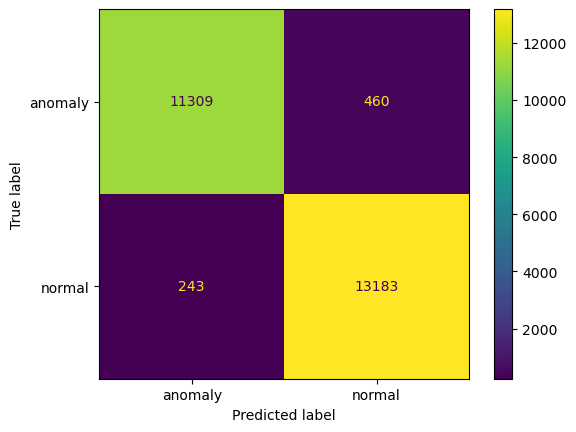

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["anomaly", "normal"])
disp.plot()


**Precision**

In [62]:
from sklearn.metrics import precision_score
print("Precisión: ",  precision_score(y_val, y_pred, pos_label = "anomaly") )


Precisión:  0.9789646814404432


**Recall**

In [64]:
from sklearn.metrics import recall_score
print("Recall: ",  recall_score(y_val, y_pred, pos_label = "anomaly") )


Recall:  0.9609142662928031


**F1**

In [65]:
from sklearn.metrics import f1_score
print("F1 score: ",  f1_score(y_val, y_pred, pos_label = "anomaly") )


F1 score:  0.9698554950473822


**Evaluaciòn del modelo con el conjunto de datos de prueba**

In [69]:
#Transformar el subconjunto de validaciòn
X_test_preparer = data_preparer.transform(X_test)

In [70]:
y_pred = clf.predict(X_test_preparer)

In [73]:
from sklearn.metrics import f1_score 
print('F1 score: ', f1_score(y_test, y_pred, pos_label='anomaly'))

F1 score:  0.9683533298556772
